### Objectiver: Predicted % chance of victory between two players in a chess match

In [1]:
import pandas as pd
import numpy as np

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from os import listdir
from os.path import isfile, join

import shap

import warnings
warnings.filterwarnings("ignore")


from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score

from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
import lightgbm as lgb

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
import sklearn.metrics as metrics

import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import cv

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

## Reading all files
* Read all json files and ELO file
* Create simple table and store them for immediate Usage

In [ ]:
# Paths to the folders contating JSON files
train_path = r'chess/train'
test_path = r'chess/test'

ELO_2014 = r'chess/rating_2014.txt'
ELO_2020 = r'chess/rating_2020.txt'

train_files = listdir(train_path)
test_files = listdir(test_path)

# Function to read all the json files and store the information in one DataFrame
def create_meta_data(train_files,test_files,ELO_2014,ELO_2020):
    
    #Initializing the DataFrame with all the appropriate columns
    train = pd.DataFrame(columns = ['name','start_date', 'end_date', 'tours', 'time_control', 'tour',
                                    'white', 'black', 'date', 'result', 'id'])
    test = pd.DataFrame(columns = ['name','start_date', 'end_date', 'tours', 'time_control', 'tour',
                                   'white', 'black', 'date', 'id'])
    
    # Processing files in train folder
    for file in train_files:
        temp = pd.read_json(train_path + '/' + file, encoding = 'latin1')
        for index in temp.index:
            games = pd.DataFrame(temp.loc[index]['games'])
            games['name'] = temp.loc[index]['name']
            games['start_date'] = temp.loc[index]['start_date']
            games['end_date'] = temp.loc[index]['end_date']
            games['tours'] = temp.loc[index]['tours']
            games['time_control'] = temp.loc[index]['time_control']
            games['tour'] = index
            train = pd.concat([train, games])
            
    # Processing files in test folder
    for file in test_files:
        temp = pd.read_json(test_path + '/' + file,  encoding = 'latin1')
        for index in temp.index:
            games = pd.DataFrame(temp.loc[index]['games'])
            games['name'] = temp.loc[index]['name']
            games['start_date'] = temp.loc[index]['start_date']
            games['end_date'] = temp.loc[index]['end_date']
            games['tours'] = temp.loc[index]['tours']
            games['time_control'] = temp.loc[index]['time_control']
            games['tour'] = index
            test = pd.concat([test, games])
        
    # Converting Date columns to Date format using pandas datetime function
    train['date'] = pd.to_datetime(train['date'])
    
    # Sorting all the rows chronologically    
    train = train.sort_values(by=['date'], ascending= True)
    test = test.sort_values(by=['date'], ascending= True)
    
    # Resetting index of the sorted rows
    train = train.reset_index(drop = True)
    test = test.reset_index(drop = True)
    
    # Saving the DataFrame for further usage
    train.to_csv('Data/Train_Master.csv', index = False)
    test.to_csv('Data/Test_Master.csv', index = False)

    
    with open(ELO_2014) as f:
        ELO_2014 = f.readlines()
    
    with open(ELO_2020) as f:
        ELO_2020 = f.readlines()
    
    ELO_2014 = pd.DataFrame([i.replace('\n','').split('\t') for i in ELO_2014], columns = ['name','ELO'])
    ELO_2020 = pd.DataFrame([i.replace('\n','').split('\t') for i in ELO_2020], columns = ['name','ELO'])

    ELO_2014.to_csv('Data/ELO_2014.csv', index = False)
    ELO_2020.to_csv('Data/ELO_2020.csv', index = False)
    
    
# Executing the funtion
create_meta_data(train_files,test_files,ELO_2014,ELO_2020)

### Loading Data

In [141]:
train = pd.read_csv('Data/Train_Master.csv')
test = pd.read_csv('Data/Test_Master.csv')

train['Year'] = train['date'].apply(lambda x: int(x[0:4]), 1)
test['Year'] = test['date'].apply(lambda x: int(x[0:4]), 1)

In [142]:
print('Total number of tournments: {}'.format(len(train.name.unique())))
print('Total nubmer of games: {}'.format(len(train)))
print('Total number of Rapid games are {} and classic games are {}'.format(train.time_control.value_counts()[0],
                                                                           train.time_control.value_counts()[1]))

Uni_players = set(list(train['white']) +  list(train['black']))
print('Total number of Unique players: {}'.format(len(Uni_players)))

# Dropping coloumns with no information.
train = train.drop(['name','start_date','end_date','tours','date','tour','id'], axis= 1)
test = test.drop(['name','start_date','end_date','tours','date','tour','id'], axis= 1)

Total number of tournments: 803
Total nubmer of games: 174118
Total number of Rapid games are 102626 and classic games are 71492
Total number of Unique players: 2133


In [185]:
stats = pd.DataFrame(zip(train.result.value_counts().index, 
                         train.result.value_counts().values),
                     columns = ['Result', 'Count'])

stats['Result'] = stats['Result'].replace(0.5, 'Draw')
stats['Result'] = stats['Result'].replace(0, 'Lose')
stats['Result'] = stats['Result'].replace(1, 'Win')

fig = px.bar(stats, y = 'Count', x = 'Result', text_auto = '.2s', title = 'Chess Outcomes')
fig.show()

In [187]:
fig = make_subplots(rows=1, 
                    cols=3, 
                    specs=[[{'type':'domain'}, {'type':'domain'}, {'type':'domain'}]],
                    subplot_titles=['Rapid', 'Classis', 'Combined'])

stats = pd.DataFrame(zip(train[train['time_control'] == 'rapid'].result.value_counts().index, 
                         train[train['time_control'] == 'rapid'].result.value_counts().values),
                     columns = ['Result', 'Count'])
fig.add_trace(go.Pie(labels=stats.Result, values=stats.Count),
              1,1)

stats = pd.DataFrame(zip(train[train['time_control'] == 'classic'].result.value_counts().index, 
                         train[train['time_control'] == 'classic'].result.value_counts().values),
                     columns = ['Result', 'Count'])
fig.add_trace(go.Pie(labels=stats.Result, values=stats.Count),
              1,2)

stats = pd.DataFrame(zip(train.result.value_counts().index, 
                         train.result.value_counts().values),
                     columns = ['Result', 'Count'])
fig.add_trace(go.Pie(labels=stats.Result, values=stats.Count),
              1,3)

# Use `hole` to create a donut-like pie chart
fig.update_traces(hole=.4, hoverinfo="label+percent+name")

fig.show()

## Feature Engineering

In [143]:
def deciles(data, col, bins = 10):
    data = data.sort_values(by = [col], ascending = True)
    l = int(len(data)/bins)
    
    decile = {}
    for i in range(bins):
        a = np.mean(data[col][i*l:(i+1)*l])
        wins = len([1 for i in data['result'][i*l:(i+1)*l] if i == 1])
        draw = len([1 for i in data['result'][i*l:(i+1)*l] if i == 0.5])
        lose = len([1 for i in data['result'][i*l:(i+1)*l] if i == 0])
        
        key = str(round(a,2))
        
        if key in decile.keys():
            decile[key] = (decile[key][0]+wins, decile[key][1]+draw, decile[key][2]+lose)
        else:
            decile[key] = (wins,draw,lose)
        
    decile = pd.DataFrame(decile, index = ['Wins', 'Draws', "Loses"]).T
    return decile

def plot_figures(n, columns, main_title,function, train):
    fig = make_subplots(rows=1, cols=n, horizontal_spacing=0.2, subplot_titles=columns)
    for i in range(0,n):
        fig.add_trace(px.imshow(function(train,columns[i]),
                                text_auto=True, title = columns[i], 
                                color_continuous_scale='RdBu_r').data[0], 1, i+1)
        
    fig.update_layout(title_text=main_title, title_x=0,
                      coloraxis=dict(colorscale='balance', colorbar_thickness=25, colorbar_x=-0.12),
                      coloraxis2=dict(colorscale='curl',colorbar_thickness=25,))
    fig.update_coloraxes(showscale=False)
    fig.show()

### Games Played prior to the Current Games

In [144]:
Exp = {i:0 for i in Uni_players}

train['White_Exp'] = 0
train['Black_Exp'] = 0

test['White_Exp'] = 0
test['Black_Exp'] = 0

for row in train.index:
    
    # Extract current game result and player's names
    p1, p2 = train['white'][row], train['black'][row]
    # Using player names as keys extract their last x games results
    b1, b2 = Exp[p1], Exp[p2]
    
    
    train['White_Exp'][row] = b1
    train['Black_Exp'][row] = b2
    Exp[p1] = b1 + 1
    Exp[p2] = b2 + 1
    
for row in test.index:
    p1, p2 = test['white'][row], test['black'][row]
    b1, b2 = Exp[p1], Exp[p2]
    
    test['White_Exp'][row] = b1
    test['Black_Exp'][row] = b2


In [145]:
fig = px.histogram(list(Exp.values()),nbins=50)
fig.show()

### Prev Probabilities

In [146]:
History = {i:[] for i in Uni_players}

train['White_Win_probability'] = 0
train['White_Draw_Probability'] = 0
train['White_Lose_probability'] = 0

test['White_Win_probability'] = 0
test['White_Draw_Probability'] = 0
test['White_Lose_probability'] = 0

train['Black_Win_probability'] = 0
train['Black_Draw_Probability'] = 0
train['Black_Lose_probability'] = 0

test['Black_Win_probability'] = 0
test['Black_Draw_Probability'] = 0
test['Black_Lose_probability'] = 0

def probability(series):
    n = len(series)
    if n == 0:
        return (0,1,0)   
    w = sum([1 for i in series if i == 1])
    d = sum([1 for i in series if i == 0.5])
    l = sum([1 for i in series if i == 0])
    return (w/n,d/n,l/n)

for row in range(0,len(train)):
    
    # Extract current game result and player's names
    p1, p2, result = train['white'][row], train['black'][row], train['result'][row]
    
    w1,d1,l1 = probability(History[p1])
    w2,d2,l2 = probability(History[p2])
    
    train['White_Win_probability'][row] = w1
    train['White_Draw_Probability'][row] = d1
    train['White_Lose_probability'][row] = l1
    
    train['Black_Win_probability'][row] = w2
    train['Black_Draw_Probability'][row] = d2
    train['Black_Lose_probability'][row] = l2
    
    History[p1] = History[p1] + [result]
    History[p2] = History[p2] + [1-result]
        
for row in range(0,len(test)):
    
    # Extract current game result and player's names
    p1, p2 = test['white'][row], test['black'][row]
    
    w1,d1,l1 = probability(History[p1])
    w2,d2,l2 = probability(History[p2])
    
    test['White_Win_probability'][row] = w1
    test['White_Draw_Probability'][row] = d1
    test['White_Lose_probability'][row] = l1
    
    test['Black_Win_probability'][row] = w2
    test['Black_Draw_Probability'][row] = d2
    test['Black_Lose_probability'][row] = l2

In [147]:
plot_figures(3, ('White_Win_probability','White_Draw_Probability','White_Lose_probability'),
             "Probability deciles vs Game Outcome (White)", deciles, train)
plot_figures(3, ('Black_Win_probability','Black_Draw_Probability','Black_Lose_probability'),
             "Probability deciles vs Game Outcome (Black)", deciles, train)

### White Vs Black

In [148]:
History = {i:{'white':[], 'black':[]} for i in Uni_players}

train['White_Bias'] = 0
train['Black_Bias'] = 0

test['White_Bias'] = 0
test['Black_Bias'] = 0

for row in range(0,len(train)):
    # Extract current game result and player's names
    p1, p2, result = train['white'][row], train['black'][row], train['result'][row]
    b1, b2 = History[p1], History[p2]
    
    train['White_Bias'][row] = sum(b1['white'])/max(len(b1['white']),1) - sum(b1['black'])/max(len(b1['black']),1)  
    train['Black_Bias'][row] = sum(b2['black'])/max(len(b2['black']),1) - sum(b2['white'])/max(len(b2['white']),1)
    
    #Update Scores
    if result!=0.5:
        History[p1]['white'] = History[p1]['white'] + [result]
        History[p2]['black'] = History[p2]['black'] + [1-result] 
    
for i in range(0,len(test)):
    # Extract current game result and player's names
    p1, p2, result = train['white'][row], train['black'][row], train['result'][row]
    
    b1, b2 = History[p1], History[p2]   
    test['White_Bias'][row] = sum(b1['white'])/max(len(b1['white']),1) - sum(b1['black'])/max(len(b1['black']),1)
    test['Black_Bias'][row] = sum(b2['black'])/max(len(b2['black']),1) - sum(b2['white'])/max(len(b2['white']),1)
    
plot_figures(2,('White_Bias','Black_Bias'), "First Move Advantage", deciles, train) 

In [149]:
Common_Matchs = {player:{} for player in Uni_players}

train['Direct_wins'] = 0
train['Direct_draws'] = 0
train['Direst_loses'] = 0

train['Common_players_wins'] = 0
train['Common_players_draws'] = 0
train['Common_players_loses'] = 0

test['Direct_wins'] = 0
test['Direct_draws'] = 0
test['Direst_loses'] = 0

test['Common_players_wins'] = 0
test['Common_players_draws'] = 0
test['Common_players_loses'] = 0


def Common_Players_Scores(x,y):
    wins = []
    loses = []
    draw = []

    for key in x.keys():
        if key in y.keys():
            a,b = np.array(x[key])/sum(x[key]), np.array(y[key])/sum(y[key])
            wins.append(a[0]-b[0])
            draw.append(a[1]-b[1])
            loses.append(a[2]-b[2])
    
    return np.array(wins).mean(), np.array(draw).mean(), np.array(loses).mean()

for row in range(0,len(train)):
    p1, p2, result = train['white'][row], train['black'][row], train['result'][row]
    b1, b2 = Common_Matchs[p1], Common_Matchs[p2]
    
    
    if p2 in b1.keys():
        v1 = b1[p2]
        v2 = b2[p1]
    else:
        v1 = [0,0,0]
        v2 = [0,0,0]
        
    train['Direct_wins'][row] = v1[0]
    train['Direct_draws'][row] = v1[1]
    train['Direst_loses'][row] = v1[2]
    
    C = Common_Players_Scores(b1,b2)
    
    train['Common_players_wins'][row] = C[0]
    train['Common_players_draws'][row] = C[1]
    train['Common_players_loses'][row] = C[2]
    
    #Update Values
    if result == 1:
        Common_Matchs[p1][p2] = [v1[0]+1, v1[0], v1[2]]
        Common_Matchs[p2][p1] = [v2[0], v2[0], v2[2]+1]
    if result == 0.5:
        Common_Matchs[p1][p2] = [v1[0], v1[0]+1, v1[2]]
        Common_Matchs[p2][p1] = [v2[0], v2[0]+1, v2[2]]
    if result == 0:
        Common_Matchs[p1][p2] = [v1[0], v1[0], v1[2]+1]
        Common_Matchs[p2][p1] = [v2[0]+1, v2[0], v2[2]]

for row in range(0,len(test)):
    p1, p2 = test['white'][row], test['black'][row]
    b1, b2 = Common_Matchs[p1], Common_Matchs[p2]
    
    
    if p2 in b1.keys():
        v1 = b1[p2]
        v2 = b2[p1]
    else:
        v1 = [0,0,0]
        
    test['Direct_wins'][row] = v1[0]
    test['Direct_draws'][row] = v1[1]
    test['Direst_loses'][row] = v1[2]
    
    C = Common_Players_Scores(b1,b2)
    
    test['Common_players_wins'][row] = C[0]
    test['Common_players_draws'][row] = C[1]
    test['Common_players_loses'][row] = C[2]
    

In [152]:
plot_figures(3,('Direct_wins','Direct_draws','Direst_loses'), "Direct Games Outcome", deciles, train) 
plot_figures(3,('Common_players_wins','Common_players_draws','Common_players_loses'), 
             "Common Player Games Outcome", deciles, train) 

In [154]:
train.fillna(0).to_csv('Data/Train_intermediate.csv',index=False)
test.fillna(0).to_csv('Data/Test_intermediate.csv',index=False)

## ELO scores calculation

In [160]:
ELO_2014 = pd.read_csv('Data/ELO_2014.csv')
ELO_2020 = pd.read_csv('Data/ELO_2020.csv')

train = pd.read_csv('Data/Train_intermediate.csv')
test = pd.read_csv('Data/Test_intermediate.csv')

In [161]:
values = list(ELO_2014.ELO) + list(ELO_2020.ELO)

ELO_2014 = dict(zip(ELO_2014['name'],ELO_2014['ELO']))
ELO_2020 = dict(zip(ELO_2020['name'],ELO_2020['ELO']))

#ELO_2014 = dict(zip(ELO_2014['name'],[2365.0]*len(ELO_2014['ELO'])))
#ELO_2020 = dict(zip(ELO_2020['name'],[2365.0]*len(ELO_2020['ELO'])))

median = np.median(np.array([int(i) for i in ELO_2014.values()]))


print('Number of Players with ELO scores:{}'.format(len(set(list(ELO_2014.keys()) + list(ELO_2020.keys())))))
print("Median:{}, Mean:{}, Min:{}, Max:{}".format(np.median(values),np.mean(values), min(values), max(values)))

Number of Players with ELO scores:285
Median:2371.5, Mean:2380.6775, Min:2301, Max:2668


In [162]:
fig = px.histogram(values,nbins=30)
fig.show()

### Assuming the Opening ELO Score to be at 2365

In [163]:
# Winning probability of the white player based on ELO scores of White and Black
def ELO_win_probability(Ra, Rb):
    if Ra == 0:Ra = 2365
    if Rb == 0:Rb = 2365
    return 1/(1+10**((Rb-Ra)/100))


# Update ELO score based on the current game output
def Update_Elo(Ra, Rb, result, e1, e2):
    if Ra == 0:Ra = 2365
    if Rb == 0:Rb = 2365
        
    Ea = ELO_win_probability(Ra, Rb)
    Eb = ELO_win_probability(Rb, Ra)
    
    k = 50
    
    if e1>=30:k=30
    if Ra >= 2500 and result == 1:k=20
    Ra = Ra + k*(result-Ea)
    
    if e2 >=30:k=30
    if Rb >= 2500 and result == 0:k=20
    Rb = Rb + k*((1-result)-Eb)
    
    return Ra, Rb



In [164]:
# For each games, compute the ELO-score and probability of winning for both the players using their previous history

train['ELO_probability'] = 0
test['ELO_probability'] = 0

train['White_ELO'] = 0
train['Black_ELO'] = 0

test['White_ELO'] = 0
test['Black_ELO'] = 0


for row in range(0,len(train)):
    
    # Extract current game result and player's names
    year = train.Year[row]
    p1, p2, result = train.white[row], train.black[row], train.result[row]
    e1, e2 = train['White_Exp'][row], train['Black_Exp'][row]
    
    
    # check if the players have ELO score or else assign the default ELO score of 2365 to them.
    if p1 in ELO_2014.keys():r1 = int(ELO_2014[p1])
    else:r1 = 2365
    if p2 in ELO_2014.keys():r2 = int(ELO_2014[p2])
    else:r2 = 2365
        
#     if year >= 2020:
#         if p1 in ELO_2020.keys():r1 = int(ELO_2020[p1])
#         if p2 in ELO_2020.keys():r2 = int(ELO_2020[p2])

    # Compute the white wining probability using ELO scores
    train['ELO_probability'][row] = ELO_win_probability(r1,r2)
    
    # Capture the ELO scores
    train['White_ELO'][row] = r1
    train['Black_ELO'][row] = r2
    
    # Update the ELO scores of the players using the current game result
    r1, r2 = Update_Elo(r1,r2, result,e1,e2)

    if year >= 2020:
        ELO_2020[p1] = r1
        ELO_2020[p2] = r2
    else:
        ELO_2014[p1] = r1
        ELO_2014[p2] = r2
        
for row in range(0,len(test)):

    # Extract current game result and player's names
    p1, p2, year = test.white[row], train.black[row], test.Year[row]
    
    # check if the players have ELO score or else assign the default ELO score of 2365 to them.
    if p1 in ELO_2014.keys():r1 = int(ELO_2014[p1])
    else:r1 = 0
    if p2 in ELO_2014.keys():r2 = int(ELO_2014[p2])
    else:r2 = 0
    if year >= 2020:
        if p1 in ELO_2020.keys():r1 = int(ELO_2020[p1])
        if p2 in ELO_2020.keys():r2 = int(ELO_2020[p2])

    # Compute the white wining probability using ELO scores
    test['ELO_probability'][row] = ELO_win_probability(r1,r2)
    
    # Capture the ELO scores
    test['White_ELO'][row] = r1
    test['Black_ELO'][row] = r2

In [194]:
plot_figures(3,('White_ELO','Black_ELO', 'ELO_probability'), 
             "Players ELO Scores and White Winning Probability", deciles, train) 


### Players ELO score comparison (Linear Function)

In [319]:
train = pd.read_csv('Data/Train_ELO_score.csv')
test = pd.read_csv('Data/Test_ELO_Score.csv')


ELO_dist = {i:{'wins':[], 'loses':[]} for i in Uni_players}

train['ELO_lin_Wins_white'] = 0
train['ELO_lin_Loses_white'] = 0
train['ELO_lin_Wins_black'] = 0
train['ELO_lin_Loses_black'] = 0

test['ELO_lin_Wins_white'] = 0
test['ELO_lin_Loses_white'] = 0
test['ELO_lin_Wins_black'] = 0
test['ELO_lin_Loses_black'] = 0

def probability(x,y, E1, E2):
    p1_win = sum([1 for i in x['wins'] if i > E2])/max(len(x['wins']),1)
    p1_lose = sum([1 for i in x['loses'] if i < E2])/max(len(x['loses']),1)
    
    p2_win = sum([1 for i in y['wins'] if i > E1])/max(len(y['wins']),1)
    p2_lose = sum([1 for i in y['loses'] if i < E1])/max(len(y['loses']),1)
    
    return p1_win,p1_lose,p2_win,p2_lose


for row in range(0, len(train)):
    p1, p2, result = train.white[row], train.black[row], train.result[row]
    ELO1,ELO2 = train['White_ELO'][row], train['Black_ELO'][row]
    
    p1_win,p1_lose,p2_win,p2_lose = probability(ELO_dist[p1],ELO_dist[p2], ELO1,ELO2)
    
    train['ELO_lin_Wins_white'][row] = p1_win
    train['ELO_lin_Loses_white'][row] = p1_lose
    train['ELO_lin_Wins_black'][row] = p2_win
    train['ELO_lin_Loses_black'][row] = p2_lose
    
    if result == 1:
        ELO_dist[p1]['wins'] = ELO_dist[p1]['wins'] + [ELO2]
        ELO_dist[p2]['loses'] = ELO_dist[p2]['loses'] + [ELO1]
        
    if result ==0:
        ELO_dist[p1]['loses'] = ELO_dist[p1]['loses'] + [ELO2]
        ELO_dist[p2]['wins'] = ELO_dist[p2]['wins'] + [ELO1]
        
        
for row in range(0, len(test)):
    p1, p2 = test.white[row], test.black[row],
    ELO1,ELO2 = test['White_ELO'][row], test['Black_ELO'][row]
    
    p1_win,p1_lose,p2_win,p2_lose = probability(ELO_dist[p1],ELO_dist[p2], ELO1,ELO2)
    
    test['ELO_lin_Wins_white'][row] = p1_win
    test['ELO_lin_Loses_white'][row] = p1_lose
    test['ELO_lin_Wins_black'][row] = p2_win
    test['ELO_lin_Loses_black'][row] = p2_lose

In [320]:
plot_figures(4,('ELO_lin_Wins_white','ELO_lin_Loses_white', 'ELO_lin_Wins_black','ELO_lin_Loses_black'), 
             "Probability using linear relation", deciles, train) 

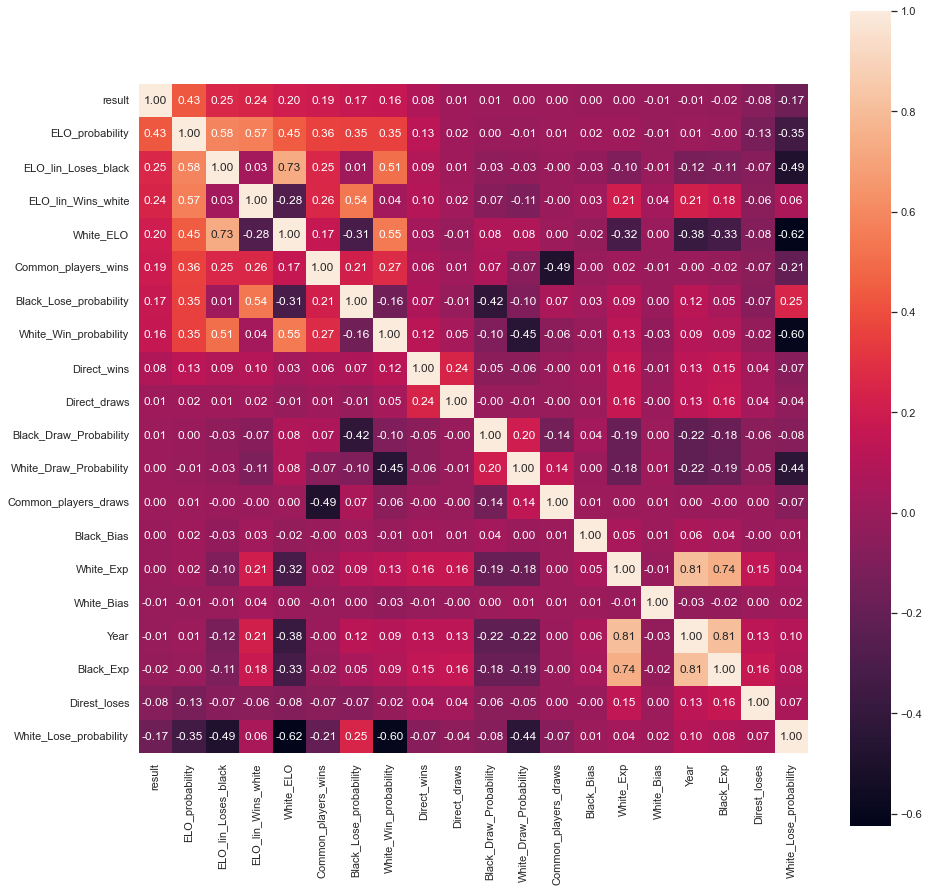

In [321]:
correlation = train.corr(method='pearson')
columns = correlation.nlargest(20, 'result').index
columns


plt.figure(figsize=(15,15)) 
correlation_map = np.corrcoef(train[columns].values.T)
sns.set(font_scale=1.0)
heatmap = sns.heatmap(correlation_map,
                      cbar=True, annot=True,
                      square=True, fmt='.2f', 
                      yticklabels=columns.values,
                      xticklabels=columns.values)

plt.show()

In [322]:
# Saving the files
train.to_csv('Data/Train_ELO_score.csv', index = False)
test.to_csv('Data/Test_ELO_Score.csv', index = False)

### Model Buidling

#### Loading data

In [ ]:
train = pd.read_csv('Data/Train_ELO_score.csv')
test = pd.read_csv('Data/Test_ELO_Score.csv')


# Dropping Unnecessary coloumns
train = train.drop(['white', 'black', 'Year','White_Exp', 'Black_Exp'], axis = 1)
test = test.drop(['white', 'black', 'Year','White_Exp', 'Black_Exp'], axis = 1)

# Converting result from continous to categorical
train['result'] = train.result.apply(lambda x: 2*(x-0.5), 1)

train['time_control'] = train['time_control'].apply(lambda x: 1 if x == 'classic' else 0,1)
test['time_control'] = test['time_control'].apply(lambda x: 1 if x == 'classic' else 0,1)

train['ELO_score_diff'] = train['White_ELO']-train['Black_ELO']

#### Fixing training and validation data set to train the model

In [ ]:
val = train.loc[150000:]
val = val.reset_index(drop = True)

train = train.loc[100000:150000]
train = train.reset_index(drop = True)

### Model Evaluation metrics

In [27]:
# Functions to compute True Positives, True Negatives, False Positives and False Negatives
def true_positive(y_true, y_pred):
    return sum([1 for yt,yp in zip(y_true, y_pred) if yt == 1 and yp == 1 ])

def true_negative(y_true, y_pred):
    return sum([1 for yt,yp in zip(y_true, y_pred) if yt == 0 and yp == 0])

def false_positive(y_true, y_pred):
    return sum([1 for yt,yp in zip(y_true, y_pred) if yt == 0 and yp == 1])

def false_negative(y_true, y_pred):
    return sum([1 for yt,yp in zip(y_true, y_pred) if yt == 1 and yp == 0])

#Computation of macro-averaged fi score
def macro_f1(y_true, y_pred):

    # find the number of classes
    num_classes = len(np.unique(y_true))

    # initialize f1 to 0
    f1 = 0
    
    # loop over all classes
    for class_ in list(y_true.unique()):
        
        # all classes except current are considered negative
        temp_true = [1 if p == class_ else 0 for p in y_true]
        temp_pred = [1 if p == class_ else 0 for p in y_pred]
        
        # compute true positive for current class
        tp = true_positive(temp_true, temp_pred)
        # compute false negative for current class
        fn = false_negative(temp_true, temp_pred)
        # compute false positive for current class
        fp = false_positive(temp_true, temp_pred)
        
        # compute recall for current class
        temp_recall = tp / (tp + fn + 1e-6)
        # compute precision for current class
        temp_precision = tp / (tp + fp + 1e-6)
        temp_f1 = 2 * temp_precision * temp_recall / (temp_precision + temp_recall + 1e-6)
        
        # keep adding f1 score for all classes
        f1 += temp_f1
        
    # calculate and return average f1 score over all classes
    f1 /= num_classes
    
    return f1

In [32]:
def Model_training(train, feature, n_splits = 5):
    lgb_scores = []
    cat_scores = []
    lm_scores = []
    
    skf = StratifiedKFold(n_splits=n_splits)
    for fold,(trn_idx,val_idx) in enumerate(skf.split(train[feature],train[target])):
    
        print("In fold ",fold+1)
        X_train,X_val = train.loc[trn_idx,feature],train.loc[val_idx,feature]
        y_train,y_val = train.loc[trn_idx,target],train.loc[val_idx,target]
    
        lgb_clf = lgb.LGBMClassifier(n_estimators=300,metric="None")
        lgb_clf.fit(X_train,y_train,eval_set=[(X_val,y_val)],
                    verbose = 200,
                    eval_metric='multi_logloss',
                    callbacks=[lgb.early_stopping(stopping_rounds=50)])
    
        fold_preds = lgb_clf.predict(X_val)
        fold_score = macro_f1(y_val,fold_preds)
        print(f"Fold LightGBM {fold+1} score: ",fold_score)
        lgb_scores.append(fold_score)
    
    
        clf = CatBoostClassifier(random_state=fold+1, loss_function='MultiClass')
        clf.fit(X_train,y_train,eval_set=[(X_val,y_val)],
                #cat_features = cat_cols,
                early_stopping_rounds=250,
                verbose=False)

        fold_preds = clf.predict(X_val)
        fold_score = macro_f1(y_val,fold_preds)
        print(f"Fold Catboot {fold+1} score: ",fold_score)
        cat_scores.append(fold_score)
     
        lm = LogisticRegression(multi_class='ovr', solver='liblinear')
        lm.fit(X_train, y_train)
    
        fold_preds = lm.predict(X_val)
        fold_score = macro_f1(y_val,fold_preds)
        print(f"Fold Logistic {fold+1} score: ",fold_score)
        lm_scores.append(fold_score)
    
    print("Overall CatBoost Model score is ",np.array(cat_scores).mean())
    print("Overall LM Model score is ",np.array(lm_scores).mean())
    print(pd.DataFrame(zip(lgb_scores, cat_scores, lm_scores),
                       columns = ['lgb_scores', 'cat_scores', 'lm_scores']))
    return lgb_clf, clf, lm


#preds = preds / 5

In [33]:
important = ['time_control']

set1 = ['ELO_probability', 
        'White_Win_probability', 'White_Draw_Probability','White_Lose_probability',
        'Black_Win_probability', 'Black_Draw_Probability', 'Black_Lose_probability']
set2 = ['Direct_wins', 'Direct_draws', 'Direst_loses',
        'Common_players_wins', 'Common_players_draws', 'Common_players_loses']
set3 = ['White_ELO', 'Black_ELO','ELO_score_diff']
set4 = ['ELO_lin_Loses_white', 'ELO_lin_Wins_black', 'ELO_lin_Loses_black']

target = 'result'

In [34]:
Set3 = Model_training(train, set3 + important, n_splits = 8)

In fold  1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[15]	valid_0's multi_logloss: 1.0283
Fold LightGBM 1 score:  0.428030806144331
Fold Catboot 1 score:  0.43781428643830433
Fold Logistic 1 score:  0.43999415428660943
In fold  2
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[18]	valid_0's multi_logloss: 1.01052
Fold LightGBM 2 score:  0.45810866446064297
Fold Catboot 2 score:  0.45879433226195127
Fold Logistic 2 score:  0.4663014419391934
In fold  3
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[37]	valid_0's multi_logloss: 0.979301
Fold LightGBM 3 score:  0.4926379971133825
Fold Catboot 3 score:  0.49286389455247387
Fold Logistic 3 score:  0.48834456219941935
In fold  4
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[37]	valid_0's multi_logloss: 0.978355
Fold LightGBM 4 score:  0.4917

In [35]:
Set1 = Model_training(train, set1 + important, n_splits = 5)

In fold  1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[13]	valid_0's multi_logloss: 1.02535
Fold LightGBM 1 score:  0.43396971807104423
Fold Catboot 1 score:  0.4418873826763232
Fold Logistic 1 score:  0.4450861406822695
In fold  2
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[50]	valid_0's multi_logloss: 0.982121
Fold LightGBM 2 score:  0.49066171768452826
Fold Catboot 2 score:  0.49177525284396556
Fold Logistic 2 score:  0.4866529415396989
In fold  3
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[78]	valid_0's multi_logloss: 0.951802
Fold LightGBM 3 score:  0.5156932973650793
Fold Catboot 3 score:  0.5171338478545325
Fold Logistic 3 score:  0.5095259881542721
In fold  4
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[82]	valid_0's multi_logloss: 0.94367
Fold LightGBM 4 score:  0.52361

In [36]:
Set2 = Model_training(train, set2 + important, n_splits = 5)
Set4 = Model_training(train, set4 + important, n_splits = 5)

In fold  1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[14]	valid_0's multi_logloss: 1.07039
Fold LightGBM 1 score:  0.29674176663755486
Fold Catboot 1 score:  0.3162982985226153
Fold Logistic 1 score:  0.3644780128265456
In fold  2
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[17]	valid_0's multi_logloss: 1.05232
Fold LightGBM 2 score:  0.41016792219222004
Fold Catboot 2 score:  0.41605927103050516
Fold Logistic 2 score:  0.4032188626272659
In fold  3
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[39]	valid_0's multi_logloss: 1.02536
Fold LightGBM 3 score:  0.45182961286265105
Fold Catboot 3 score:  0.4518435429372157
Fold Logistic 3 score:  0.4172534684784352
In fold  4
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[57]	valid_0's multi_logloss: 1.0279
Fold LightGBM 4 score:  0.4347168

In [38]:
Mid_stage = pd.DataFrame(Set3[2].predict_proba(train[set3 + important]), columns = ['lose','draw','win'])
Mid_stage['Set1'] = Set1[1].predict(train[set1 + important])
Mid_stage['Set2'] = Set2[1].predict(train[set2 + important])
Mid_stage['Set4'] = Set4[1].predict(train[set4 + important])
Mid_stage['result'] = train['result']

In [40]:
feature = ['lose', 'draw', 'win', 'Set1', 'Set2', 'Set4']
models = Model_training(Mid_stage, feature, n_splits = 5)

In fold  1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[19]	valid_0's multi_logloss: 1.01653
Fold LightGBM 1 score:  0.45747609786773147
Fold Catboot 1 score:  0.45836570386807
Fold Logistic 1 score:  0.45652221050986347
In fold  2
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[26]	valid_0's multi_logloss: 0.978084
Fold LightGBM 2 score:  0.5053467758201621
Fold Catboot 2 score:  0.505120789705496
Fold Logistic 2 score:  0.4987678779939253
In fold  3
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[42]	valid_0's multi_logloss: 0.951134
Fold LightGBM 3 score:  0.5280194190791433
Fold Catboot 3 score:  0.5284947492923249
Fold Logistic 3 score:  0.5239283101907469
In fold  4
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[51]	valid_0's multi_logloss: 0.942474
Fold LightGBM 4 score:  0.53842840

In [43]:
X_val, y_val = Mid_stage[feature],Mid_stage['result']

              precision    recall  f1-score   support

        -1.0       0.59      0.41      0.48     44640
         0.0       0.47      0.59      0.52     67835
         1.0       0.59      0.55      0.57     61643

    accuracy                           0.53    174118
   macro avg       0.55      0.52      0.52    174118
weighted avg       0.54      0.53      0.53    174118



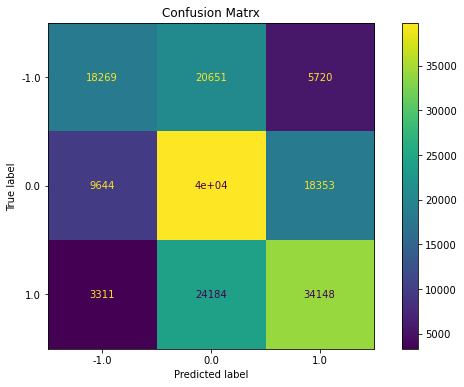

In [46]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_title('Confusion Matrx')
disp =metrics.plot_confusion_matrix(models[0], X_val, y_val, ax = ax)
disp.confusion_matrix
print(metrics.classification_report(y_val, models[0].predict(X_val)))

In [47]:
result = models[0].predict(test)
test = pd.read_csv('Data/Test_Master.csv')
test['result'] = result

ValueError: Number of features of the model must match the input. Model n_features_ is 6 and input n_features is 22

In [48]:
test.to_csv('Submission.csv', index = False)